In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers, losses

2024-07-13 22:40:30.381021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 22:40:30.381468: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 22:40:30.383607: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 22:40:30.390318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 22:40:30.401190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    extract=True, cache_dir='stack_overflot_16k',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset))


In [3]:
os.listdir(dataset_dir)

['stack_overflow_16k', 'README.md', 'train', 'test']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [5]:
sample_file = os.path.join(train_dir, 'java/1053.txt')
with open(sample_file) as f:
  print(f.read())

"how do i replace a letter in a string without .replace in blank i need help finishing this code. i'm trying to go through every letter in a word and changing the lettertoreplace with the replacingletter.  the problem is that i can't use .replace  ..please help..public string replaceletter(string word, char lettertoreplace, char replacingletter).{.    string ans = """";.    for(int i = 0; i &lt; word.length(); i++).    {.        char current = word.charat(i);.        if(current == lettertoreplace).        {.           lettertoreplace = replacingletter;.        }.        ans += character.tostring(word.charat(i));.    }.    return ans;.}"



In [6]:
batch_size = 32
seed = 42
train_dir = os.path.join(dataset_dir,'train')
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2024-07-13 22:40:35.144469: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(1):
    print("Review", text_batch.numpy()[i])
    print("Label",  raw_train_ds.class_names[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

2024-07-13 22:40:35.421449: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])
print("total labels: ", len(raw_train_ds.class_names))

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python
total labels:  4


In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
test_dir = os.path.join(dataset_dir, 'test')
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)


Found 8000 files belonging to 4 classes.


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [13]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


2024-07-13 22:40:36.425906: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("\n Label:", raw_train_ds.class_names[first_label])
print("\n Vectorized review", vectorize_text(first_question, first_label))

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)

 Label: java

 Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90, 

In [16]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[100])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


1287 --->  into
 313 --->  source
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
embedding_dim = 16


In [19]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy']
)


In [21]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10


/home/johnson/sources/python/tensorflow-keras/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3054 - loss: 1.3787 - val_accuracy: 0.3200 - val_loss: 1.3539
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3884 - loss: 1.3367 - val_accuracy: 0.4144 - val_loss: 1.2989
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4995 - loss: 1.2800 - val_accuracy: 0.6019 - val_loss: 1.2188
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5778 - loss: 1.2012 - val_accuracy: 0.6281 - val_loss: 1.1317
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6316 - loss: 1.1137 - val_accuracy: 0.6569 - val_loss: 1.0520
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6652 - loss: 1.0354 - val_accuracy: 0.6750 - val_loss: 0.9798
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6790 - loss: 0.9636 - val_accuracy: 0.7138 - val_loss: 0.9177
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7147 - loss: 0.8969 - val_accuracy: 0.7188 - val_

In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7061 - loss: 0.8138
Loss:  0.8224424123764038
Accuracy:  0.7008749842643738


In [23]:
history_dict = history.history
history_dict.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

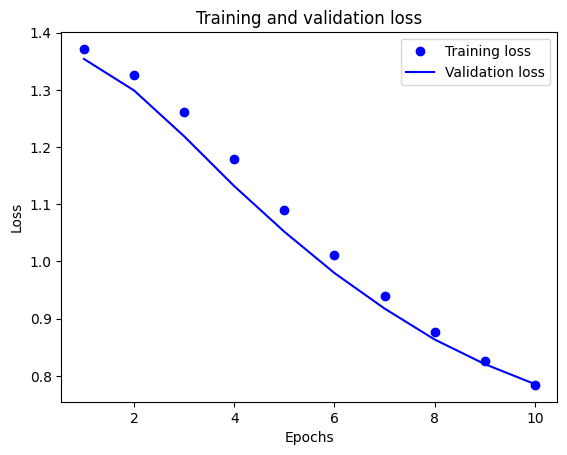

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


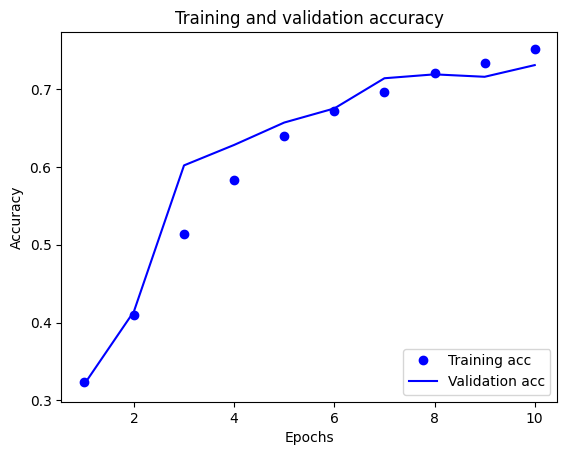

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [37]:
raw_test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy,*is_anything_else_being_returned  = export_model.evaluate(raw_test_ds)
print(accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7049 - loss: 0.0000e+00
0.0


In [41]:
examples = tf.constant([
  "how to count the lenght of a string in python ?",
    "from os import path",
    "Aggregate in C#"
])

export_model.predict(examples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[0.6399174 , 0.6063023 , 0.64454705, 0.6121559 ],
       [0.630793  , 0.6011779 , 0.6481832 , 0.62299824],
       [0.6341476 , 0.5976775 , 0.6533123 , 0.6181739 ]], dtype=float32)

In [43]:
raw_train_ds.class_names[np.argmax(prediction[0])]
raw_train_ds.class_names[np.argmax(prediction[1])]
raw_train_ds.class_names[np.argmax(prediction[2])]
np.argmax(prediction)


10

In [32]:
prediction

array([[0.6399174 , 0.6063023 , 0.64454705, 0.6121559 ],
       [0.630793  , 0.6011779 , 0.6481832 , 0.62299824],
       [0.6341476 , 0.5976775 , 0.6533123 , 0.6181739 ]], dtype=float32)